In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install timm
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 15.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 29.9 MB/s eta 0:00:00


In [ ]:
import torch
import transformers
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
# from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer, AlbertModel
import timm
import tensorflow as tf
from torchvision.transforms import ToTensor
import torchmetrics
from torchmetrics.classification import MulticlassPrecision,MulticlassRecall

In [ ]:
# Define hyperparameters
learning_rate = 0.001
num_epochs = 2
batch_size = 16
num_classes = 2  # Number of sentiment classes (e.g., negative, neutral, positive)

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

# Define dataset class
class SentimentDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #print(self.data.iloc[idx, 0], str(self.data.iloc[idx, 1]))
        print("Data found")
        text = self.data.iloc[idx, 0]

        try:
          image_path = "/content/drive/MyDrive/Major Project/Images/"+str(self.data.iloc[idx, 1])
          image = Image.open(image_path).convert('RGB')
        except:
          return None, None, None

        if self.transform:
            image = self.transform(image)

        label = self.data.iloc[idx, 2]
        return text,image,label #{'text': text, 'image': image, 'label': label}

In [ ]:
# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load dataset and dataloaders
train_dataset = SentimentDataset('/content/drive/MyDrive/Major Project/Individual Derogatory Posts/train.csv', transform=data_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SentimentDataset('/content/drive/MyDrive/Major Project/Individual Derogatory Posts/val.csv', transform=data_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
test_dataset = SentimentDataset('/content/drive/MyDrive/Major Project/Individual Derogatory Posts/val.csv', transform=data_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_dataset))

576


Updated Model

In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalClassifier, self).__init__()

        # Text encoder using BERT
        # self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        # self.text_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.text_tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
        self.bert_model = AlbertModel.from_pretrained("albert-base-v2")

        # Image encoder using Vision Transformer
        self.image_encoder = timm.create_model('vit_base_patch16_224', pretrained=True)

        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=768, nhead=12), num_layers=6)

        # Fully connected layer for classification
        self.fc = nn.Linear(768, num_classes).cuda()

        # Define linear layers for computing the attention scores
        input_size = 768
        self.attention_query = nn.Linear(input_size, input_size)
        self.attention_key = nn.Linear(input_size, input_size)

        # Define a linear layer for the output
        self.out_layer = nn.Linear(input_size, input_size)

        self.dropout = nn.Dropout(0.2)

        #device = torch.device("cuda")
        self.bert_model.to(device)
        #self.image_encoder.to(device)
        self.transformer_encoder.to(device)
        self.attention_query.to(device)
        self.attention_key.to(device)
        self.out_layer.to(device)
        self.dropout.to(device)

    def cross(self, x1, x2):
        # Move the inputs to the GPU device
        #device = x1.device
        q = self.attention_query(x1.to(device))
        k = self.attention_key(x2.to(device))

        # Compute the attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1))

        # Compute the attention weights and apply them to x2
        attn_weights = torch.softmax(attn_scores, dim=-1)
        x2_attended = torch.matmul(attn_weights.transpose(-2, -1), x2.to(device))

        # Combine the attended tensor and the input tensor using a residual connection
        combined = x1.to(device) + x2_attended

        # Apply a linear layer to the combined tensor
        out = self.out_layer(combined)

        return out.to(x1.device)

    def forward(self, text, image):
        # Text encoding using BERT
        input_ids = self.text_tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512)['input_ids'].to(device)
        attention_mask = self.text_tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512)['attention_mask'].to(device)
        bert_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]  # Using the first token's hidden state as the encoding

        # Image encoding using Vision Transformer
        image_encoding = self.image_encoder.forward_features(image)

        # Concatenate text and image encodings
        # encoding = torch.cat((bert_output.cuda(), image_encoding[:,0,:].cuda()), dim=1)

        # Instantiate the cross-attention module
        #cross_att = CrossAttention(input_size=768)

        print("Encoded")
        # Compute the attended tensor
        encoding = self.cross(bert_output.cuda(), image_encoding[:,0,:].cuda())

        # Apply transformer encoder
        encoding = encoding.unsqueeze(1)  # add sequence length dimension
        encoding = self.transformer_encoder(encoding)
        encoding = encoding.squeeze(1)  # remove sequence length dimension
        #print(encoding.size())

        # Classification using fully connected layer
        x = self.fc(encoding)
        #print(x.size())
        return x


In [ ]:
model = MultimodalClassifier(2)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=5e-5)
optimizer.zero_grad()

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("Epoch: ",epoch)
    i = 0
    running_loss = 0.0
    for data in train_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        text, image, label = data
        if text == None:
          continue

        # image = ToTensor(Image.open(image))
        #Load the image first then turn it into tensor
        # image = image.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(text, image)
        label = label.type(torch.LongTensor)
        # print(outputs)
        outputs, label = outputs.to(device), label.to(device)
        loss = criterion(outputs, label)
        loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print("Epoch: ",epoch," Data: ",i," having ",len(text)," data points trained")
        i = i+1

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(running_loss)  # milliseconds

Epoch:  0
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Encoded
Epoch:  0  Data:  0  having  16  data points trained
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Encoded
Epoch:  0  Data:  1  having  16  data points trained
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Encoded
Epoch:  0  Data:  2  having  16  data points trained
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Encoded
Epoch:  0  Data:  3  having  16  data points trained
Data found
Data found
Data found
Data foun

In [ ]:
#path = "/content/drive/MyDrive/TwitterModelProject/Malay_checkpoint.t7"
path = "/content/drive/MyDrive/ML_DRIVE/Sayak_model_albert.t7"
torch.save(model.state_dict(), path)

In [ ]:
'''
import zipfile

# Extract the checkpoint file
with zipfile.ZipFile('/content/drive/MyDrive/Major Project/Individual Derogatory Posts/v1_checkpoint.t7', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Major_Project/weights')
'''


In [ ]:
#Loading the model

#checkpoint=torch.load('/content/drive/MyDrive/Major_Project/weights/v1_checkpoint/data.pkl',map_location=torch.device('cpu'))

#model.load_state_dict(checkpoint['state_dict'])

In [ ]:


model.eval()
cuda0 = torch.device('cuda:0')
correct = 0
total = 0
preds=torch.empty(0, device=cuda0)
target=torch.empty(0,device=cuda0)
label=torch.empty(0,device=cuda0)

with torch.no_grad():
    for i, data in enumerate(val_dataloader, 0):
        text, image, label = data
        label=label.to(cuda0)
        outputs = model(text, image).cuda()
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        preds=torch.cat((preds,predicted))
        target=torch.cat((target,label)).to(cuda0)
        total += label.size(0)
        correct += (predicted == label.cuda()).sum().item()

print('Accuracy of the network on the validation set: %d %%' % (
    100 * correct / total))




Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Encoded
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Encoded
tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Encoded
tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Data found
Encoded
tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1

In [ ]:
print('Accuracy of the network on the validation set: %d %%' % (
    100 * correct / total))

preds=preds.to(cuda0)
target=target.to(cuda0)
precision = MulticlassPrecision(num_classes=2).to(cuda0)
print('Precision of the network on the validation set:' , precision(preds,target))

recall = MulticlassRecall(num_classes=2).to(cuda0)
print('Recall of the network on the validation set:' , recall(preds,target))


Accuracy of the network on the validation set: 95 %
Precision of the network on the validation set: tensor(0.9727, device='cuda:0')
Recall of the network on the validation set: tensor(0.9250, device='cuda:0')


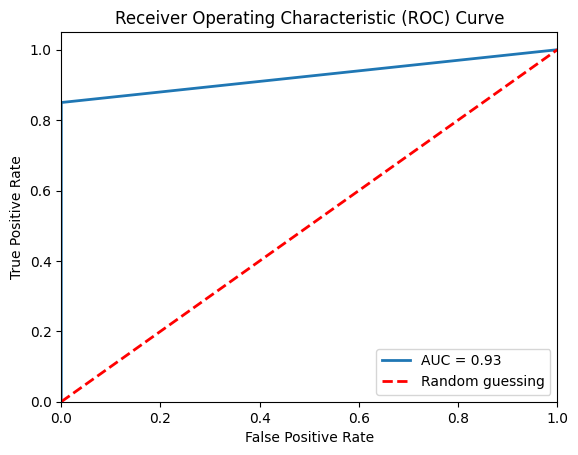

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert torch tensors to numpy arrays
preds_np = preds.cpu().detach().numpy()
target_np = target.cpu().detach().numpy()

# Compute false positive rate, true positive rate and threshold values for ROC curve
fpr, tpr, thresholds = roc_curve(target_np, preds_np)

# Compute AUC value
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
test_text = ["I love you", "Fuck you", "Kill them all muslims", "It 's another way to destroy Hungarians on top of promoting * * * * * * music , race mixing and pornography"]
test_image = torch.randn(2, 3, 224, 224)  # Example random image tensor of shape (batch_size, channels, height, width)

# Put model in evaluation mode
model.eval()

# Disable gradient computation since we're not training
with torch.no_grad():
    # Convert test_text to a list of strings (if it's not already)
    if not isinstance(test_text, list):
        test_text = list(test_text)

    # Convert test_image to a tensor
    test_image = test_image.clone().detach()

    # Make predictions
    predictions = model(test_text, test_image).cuda()
    _, predicted = torch.max(predictions.data, -1)
    print(predicted)

    # Convert predictions to class labels (assuming 2 classes)
    class_labels = torch.argmax(predictions, dim=1).tolist()

# Print class labels
print(class_labels)


Encoded


RuntimeError: ignored